In [1]:
import time
import copy
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


In [2]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [68]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
device = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Hyperparameters
RANDOM_SEED = 43

Device: cuda:0


In [69]:
set_deterministic
set_all_seeds(RANDOM_SEED)

# 1. Load Datasets

In [49]:
df = pd.read_csv('datasets/selected_2000user_v2.csv')
df

,MeterID,DATE-Time,KWH,user
0,6200093839,2021-01-01 00:00:00,0.602,0
1,6200093839,2021-01-01 00:15:00,0.589,0
2,6200093839,2021-01-01 00:30:00,0.410,0
3,6200093839,2021-01-01 00:45:00,0.495,0
4,6200093839,2021-01-01 01:00:00,0.450,0
...,...,...,...,...
40181914,6200051044,2021-07-31 22:45:00,0.473,2000
40181915,6200051044,2021-07-31 23:00:00,0.461,2000
40181916,6200051044,2021-07-31 23:15:00,0.445,2000
40181917,6200051044,2021-07-31 23:30:00,0.460,2000


In [72]:
random.seed(RANDOM_SEED)
# Get the list of unique user IDs in the DataFrame
unique_users = df['user'].unique().tolist()

# Randomly select `num_users` from the list of unique user IDs
selected_users = sorted(random.sample(unique_users, 10))

In [73]:
selected_users

[78, 294, 585, 757, 947, 1375, 1425, 1430, 1561, 1964]

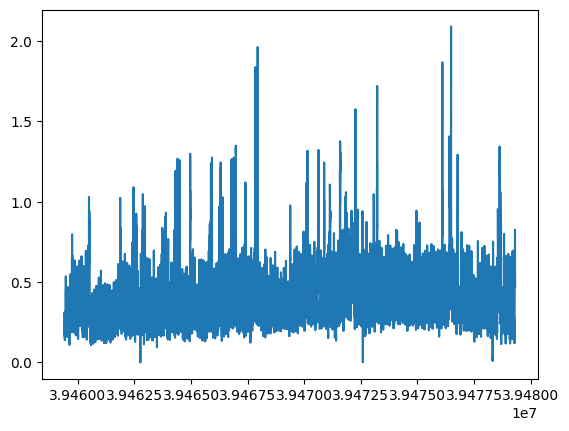

In [83]:
df[df['user']==1964]['KWH'].plot();

In [84]:
users_10_list = pd.read_csv('datasets/users_10_list.csv')
users_10_list

,user
0,53
1,240
2,257
3,347
4,471
5,503
6,543
7,1493
8,1673
9,1681


In [85]:
num_matches = np.sum(np.array(selected_users) == np.array(users_10_list))
print(num_matches)

0


In [86]:
df = df[df['user'].isin(selected_users)]
print(df['user'].nunique())
df

10


,MeterID,DATE-Time,KWH,user
1747916,6200112219,2021-01-01 00:00:00,0.074,78
1747917,6200112219,2021-01-01 00:15:00,0.073,78
1747918,6200112219,2021-01-01 00:30:00,0.080,78
1747919,6200112219,2021-01-01 00:45:00,0.078,78
1747920,6200112219,2021-01-01 01:00:00,0.058,78
...,...,...,...,...
39479314,6200046509,2021-07-31 22:45:00,0.506,1964
39479315,6200046509,2021-07-31 23:00:00,0.481,1964
39479316,6200046509,2021-07-31 23:15:00,0.503,1964
39479317,6200046509,2021-07-31 23:30:00,0.489,1964


In [87]:
# Updated
def clean_data(df, user_id):
    # Select the data for the specified user
    user_data = df[df['user']==int(user_id)]

    # Drop not useful columns
    user_data['DATE-Time'] = pd.to_datetime(user_data['DATE-Time'], infer_datetime_format=True)
    user_data.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_data = user_data.set_index('DATE-Time').resample("15T").mean()
    
    # Convert the index to a DatetimeIndex object
    user_data.index = pd.to_datetime(user_data.index)

    # Count the number of zero values in each day
    zero_counts = user_data.groupby(user_data.index.floor('D'))['KWH'].apply(lambda x: (x == 0).sum())

    # Get the dates where the number of zero values is less than or equal to 48
    valid_dates = zero_counts[zero_counts <= 48].index

    # Drop the dates where the number of zero values is greater than 48
    user_data = user_data[user_data.index.floor('D').isin(valid_dates)]

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_data.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_data_clean = user_data[~user_data.index.to_series().dt.date.isin(missing_dates)]
    
    if user_data_clean.empty:
        return None

    return user_data_clean

In [88]:
# def create_windowed_dataset(data, window_size=96):
#     # Calculate the number of windows that fit in the data
#     num_windows = len(data) // window_size
    
#     # Truncate data to fit into windowed data exactly
#     data = data[:num_windows*window_size]
    
#     # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
#     # Here we're adding an extra dimension to the data to represent the features, which is 1 in our case
#     windowed_data = np.reshape(data, (num_windows, window_size, 1))
    
#     return windowed_data

In [89]:
# def normalize_and_create_windowed_data(data, window_size=96, val_size=0.2, test_size=0.5, RANDOM_SEED=42):
#     # Split the data into train, validation, and test sets
#     train_data, val_data = train_test_split(data,
#                                             test_size=val_size,
#                                             shuffle=True,
#                                             random_state=RANDOM_SEED)
#     val_data, test_data = train_test_split(val_data,
#                                            test_size=test_size,
#                                            shuffle=True,
#                                            random_state=RANDOM_SEED)

#     # Initialize a MinMaxScaler object
#     scaler = MinMaxScaler()

#     # Fit the scaler to the train_data and transform it
#     train_data_normalized = scaler.fit_transform(train_data)

#     # Use the same scaler to transform the validation and test sets
#     val_data_normalized = scaler.transform(val_data)
#     test_data_normalized = scaler.transform(test_data)

#     # Create windowed datasets
#     train_data_windowed = create_windowed_dataset(train_data_normalized, window_size)
#     val_data_windowed = create_windowed_dataset(val_data_normalized, window_size)
#     test_data_windowed = create_windowed_dataset(test_data_normalized, window_size)

#     return train_data_windowed, val_data_windowed, test_data_windowed

In [90]:
def create_windowed_dataset(data, window_size=96):
    num_windows = len(data) // window_size
    data = data[:num_windows * window_size]
    windowed_data = np.reshape(data, (num_windows, window_size, 1))
    return windowed_data

def normalize_and_create_windowed_data(data, window_size=96, val_size=0.1, test_size=0.1, RANDOM_SEED=42):
    # Calculate the split indices
    train_split = int(len(data) * (1 - val_size - test_size))
    val_split = int(len(data) * (1 - test_size))
    
    # Split the data into train, validation, and test sets without shuffling
    train_data = data[:train_split]
    val_data = data[train_split:val_split]
    test_data = data[val_split:]

    # Initialize a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler to the train_data and transform it
    train_data_normalized = scaler.fit_transform(train_data)

    # Use the same scaler to transform the validation and test sets
    val_data_normalized = scaler.transform(val_data)
    test_data_normalized = scaler.transform(test_data)

    # Create windowed datasets
    train_data_windowed = create_windowed_dataset(train_data_normalized, window_size)
    val_data_windowed = create_windowed_dataset(val_data_normalized, window_size)
    test_data_windowed = create_windowed_dataset(test_data_normalized, window_size)

    return train_data_windowed, val_data_windowed, test_data_windowed


In [91]:
# Create empty lists to store the normalized data for each user
train_data_list = []
val_data_list = []
test_data_list = []

# Iterate through the user IDs in the users_10_list
for user_id in selected_users:
    # Clean the data for the current user
    user_clean_data = clean_data(df, user_id)
    if user_clean_data is None:
        # If the cleaned data is empty, skip to the next user
        print(f"Deleted {user_id}")
        continue
    print(f"User {user_id} clean data shape: {user_clean_data.shape}")
    
    # Normalize the cleaned data and split it into train, validation, and test sets
    train_data_windowed, val_data_windowed, test_data_windowed = normalize_and_create_windowed_data(user_clean_data)
    
    # Print the shape of the train_data_windowed for the current user
    print(f"User {user_id} train shape: {train_data_windowed.shape}, validation shape: {val_data_windowed.shape},test shape: {test_data_windowed.shape}")

    # Append the normalized data to the respective lists
    train_data_list.append(train_data_windowed)
    val_data_list.append(val_data_windowed)
    test_data_list.append(test_data_windowed)

# Concatenate the data for all users
train_data_all = np.concatenate(train_data_list, axis=0)
val_data_all = np.concatenate(val_data_list, axis=0)
test_data_all = np.concatenate(test_data_list, axis=0)

print(f"Train data shape: {train_data_all.shape}")
print(f"Validation data shape: {val_data_all.shape}")
print(f"Test data shape: {test_data_all.shape}")

User 78 clean data shape: (19008, 1)
User 78 train shape: (158, 96, 1), validation shape: (19, 96, 1),test shape: (19, 96, 1)
User 294 clean data shape: (21120, 1)
User 294 train shape: (176, 96, 1), validation shape: (22, 96, 1),test shape: (22, 96, 1)
User 585 clean data shape: (16608, 1)
User 585 train shape: (138, 96, 1), validation shape: (17, 96, 1),test shape: (17, 96, 1)
User 757 clean data shape: (17088, 1)
User 757 train shape: (142, 96, 1), validation shape: (17, 96, 1),test shape: (17, 96, 1)
User 947 clean data shape: (17664, 1)
User 947 train shape: (147, 96, 1), validation shape: (18, 96, 1),test shape: (18, 96, 1)
User 1375 clean data shape: (19296, 1)
User 1375 train shape: (160, 96, 1), validation shape: (20, 96, 1),test shape: (20, 96, 1)
User 1425 clean data shape: (16128, 1)
User 1425 train shape: (134, 96, 1), validation shape: (16, 96, 1),test shape: (16, 96, 1)
User 1430 clean data shape: (14304, 1)
User 1430 train shape: (119, 96, 1), validation shape: (14, 96,

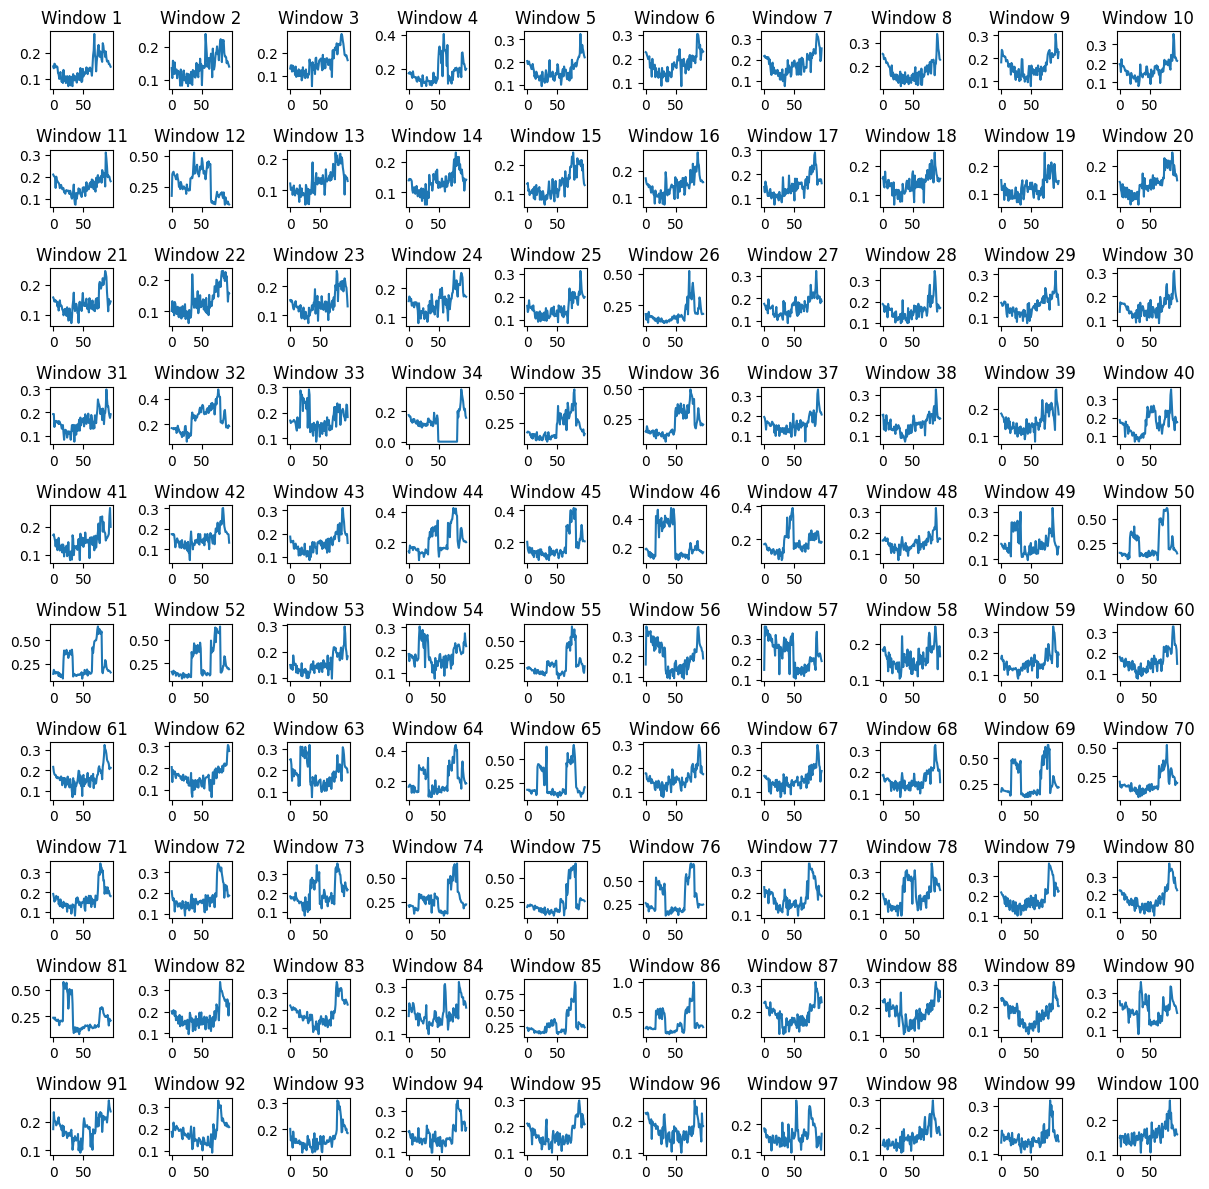

In [92]:
import matplotlib.pyplot as plt

# Number of windows to plot
num_windows_to_plot = 100

# Create a grid of subplots
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(12, 12))

# Iterate over the desired number of windows
for i in range(num_windows_to_plot):
    # Get the current axis from the subplot grid
    ax = axes[i // 10, i % 10]

    # Plot the windowed data on the current axis
    ax.plot(train_data_windowed[i])

    # Set the title for the current axis
    ax.set_title(f"Window {i+1}")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()


In [93]:
# Save the data
np.save('datasets/Norm_datasets/train_data_10_users_random.npy', train_data_all)
np.save('datasets/Norm_datasets/val_data_10_users_random.npy', val_data_all)
np.save('datasets/Norm_datasets/test_data_10_users_random.npy', test_data_all)

# Load the data
train_data_all_loaded = np.load('datasets/Norm_datasets/train_data_10_users_random.npy')
val_data_all_loaded = np.load('datasets/Norm_datasets/val_data_10_users_random.npy')
test_data_all_loaded = np.load('datasets/Norm_datasets/test_data_10_users_random.npy')

# Check if the loaded data has the same shape as the original data
print(f"Loaded train data shape: {train_data_all_loaded.shape}")
print(f"Loaded validation data shape: {val_data_all_loaded.shape}")
print(f"Loaded test data shape: {test_data_all_loaded.shape}")

Loaded train data shape: (1489, 96, 1)
Loaded validation data shape: (182, 96, 1)
Loaded test data shape: (182, 96, 1)
